Name: Sree Swiya Yarlagadda

Github Username: https://github.com/swiyasree

USC ID: 4295-5564-10

In [1]:
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

1. Tree-Based Methods

(a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/ APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test
set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are nu- meric.

In [3]:
train_data = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20, na_values='na')
train_data['class'] = train_data['class'].apply(lambda x: 1 if x == 'pos' else 0)
print(train_data.shape)

(60000, 171)


In [4]:
test_data = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20, na_values='na')
test_data['class'] = test_data['class'].apply(lambda x: 1 if x == 'pos' else 0)
print(test_data.shape)

(16000, 171)


In [5]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)
columns = combined_data.columns
combined_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,0,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,0,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,0,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


(b) Data Preparation
This data set has missing values. When the number of data with missing values
is significant, discarding them is not a good idea. 

i. Research what types of techniques are usually used for dealing with data with missing values.2 Pick at least one of them and apply it to this data in the next steps.3

In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_imputed = pd.DataFrame(imputer.fit_transform(train_data), columns=columns)
test_imputed = pd.DataFrame(imputer.fit_transform(test_data), columns=columns)
print(train_imputed.shape)
print(test_imputed.shape)
combined_data = pd.DataFrame(imputer.fit_transform(combined_data), columns=columns)

(60000, 171)
(16000, 171)


In [7]:
X_train = train_data[columns[1:]]
Y_train = train_data[columns[0]]

X_test = test_data[columns[1:]]
Y_test = test_data[columns[0]]

ii. For each of the 170 features, calculate the coefficient of variation CV = ms , where s is sample standard deviation and m is sample mean.

In [8]:
combined_features = pd.concat([X_train, X_test], ignore_index=True)
coeff_variation = combined_features.apply(lambda val: np.std(val) / np.mean(val))
coeff_variation_sorted = coeff_variation.sort_values(ascending=False)
coeff_variation_sorted

cf_000    239.002502
co_000    238.548016
ad_000    238.369713
cs_009    193.617365
dj_000    126.444421
             ...    
bk_000      0.929755
bq_000      0.922843
cb_000      0.908617
br_000      0.907202
cd_000      0.000000
Length: 170, dtype: float64

iii. Plot a correlation matrix for your features using pandas or any other tool.

Text(0.5, 1.0, 'Correlation Matrix of Combined Features')

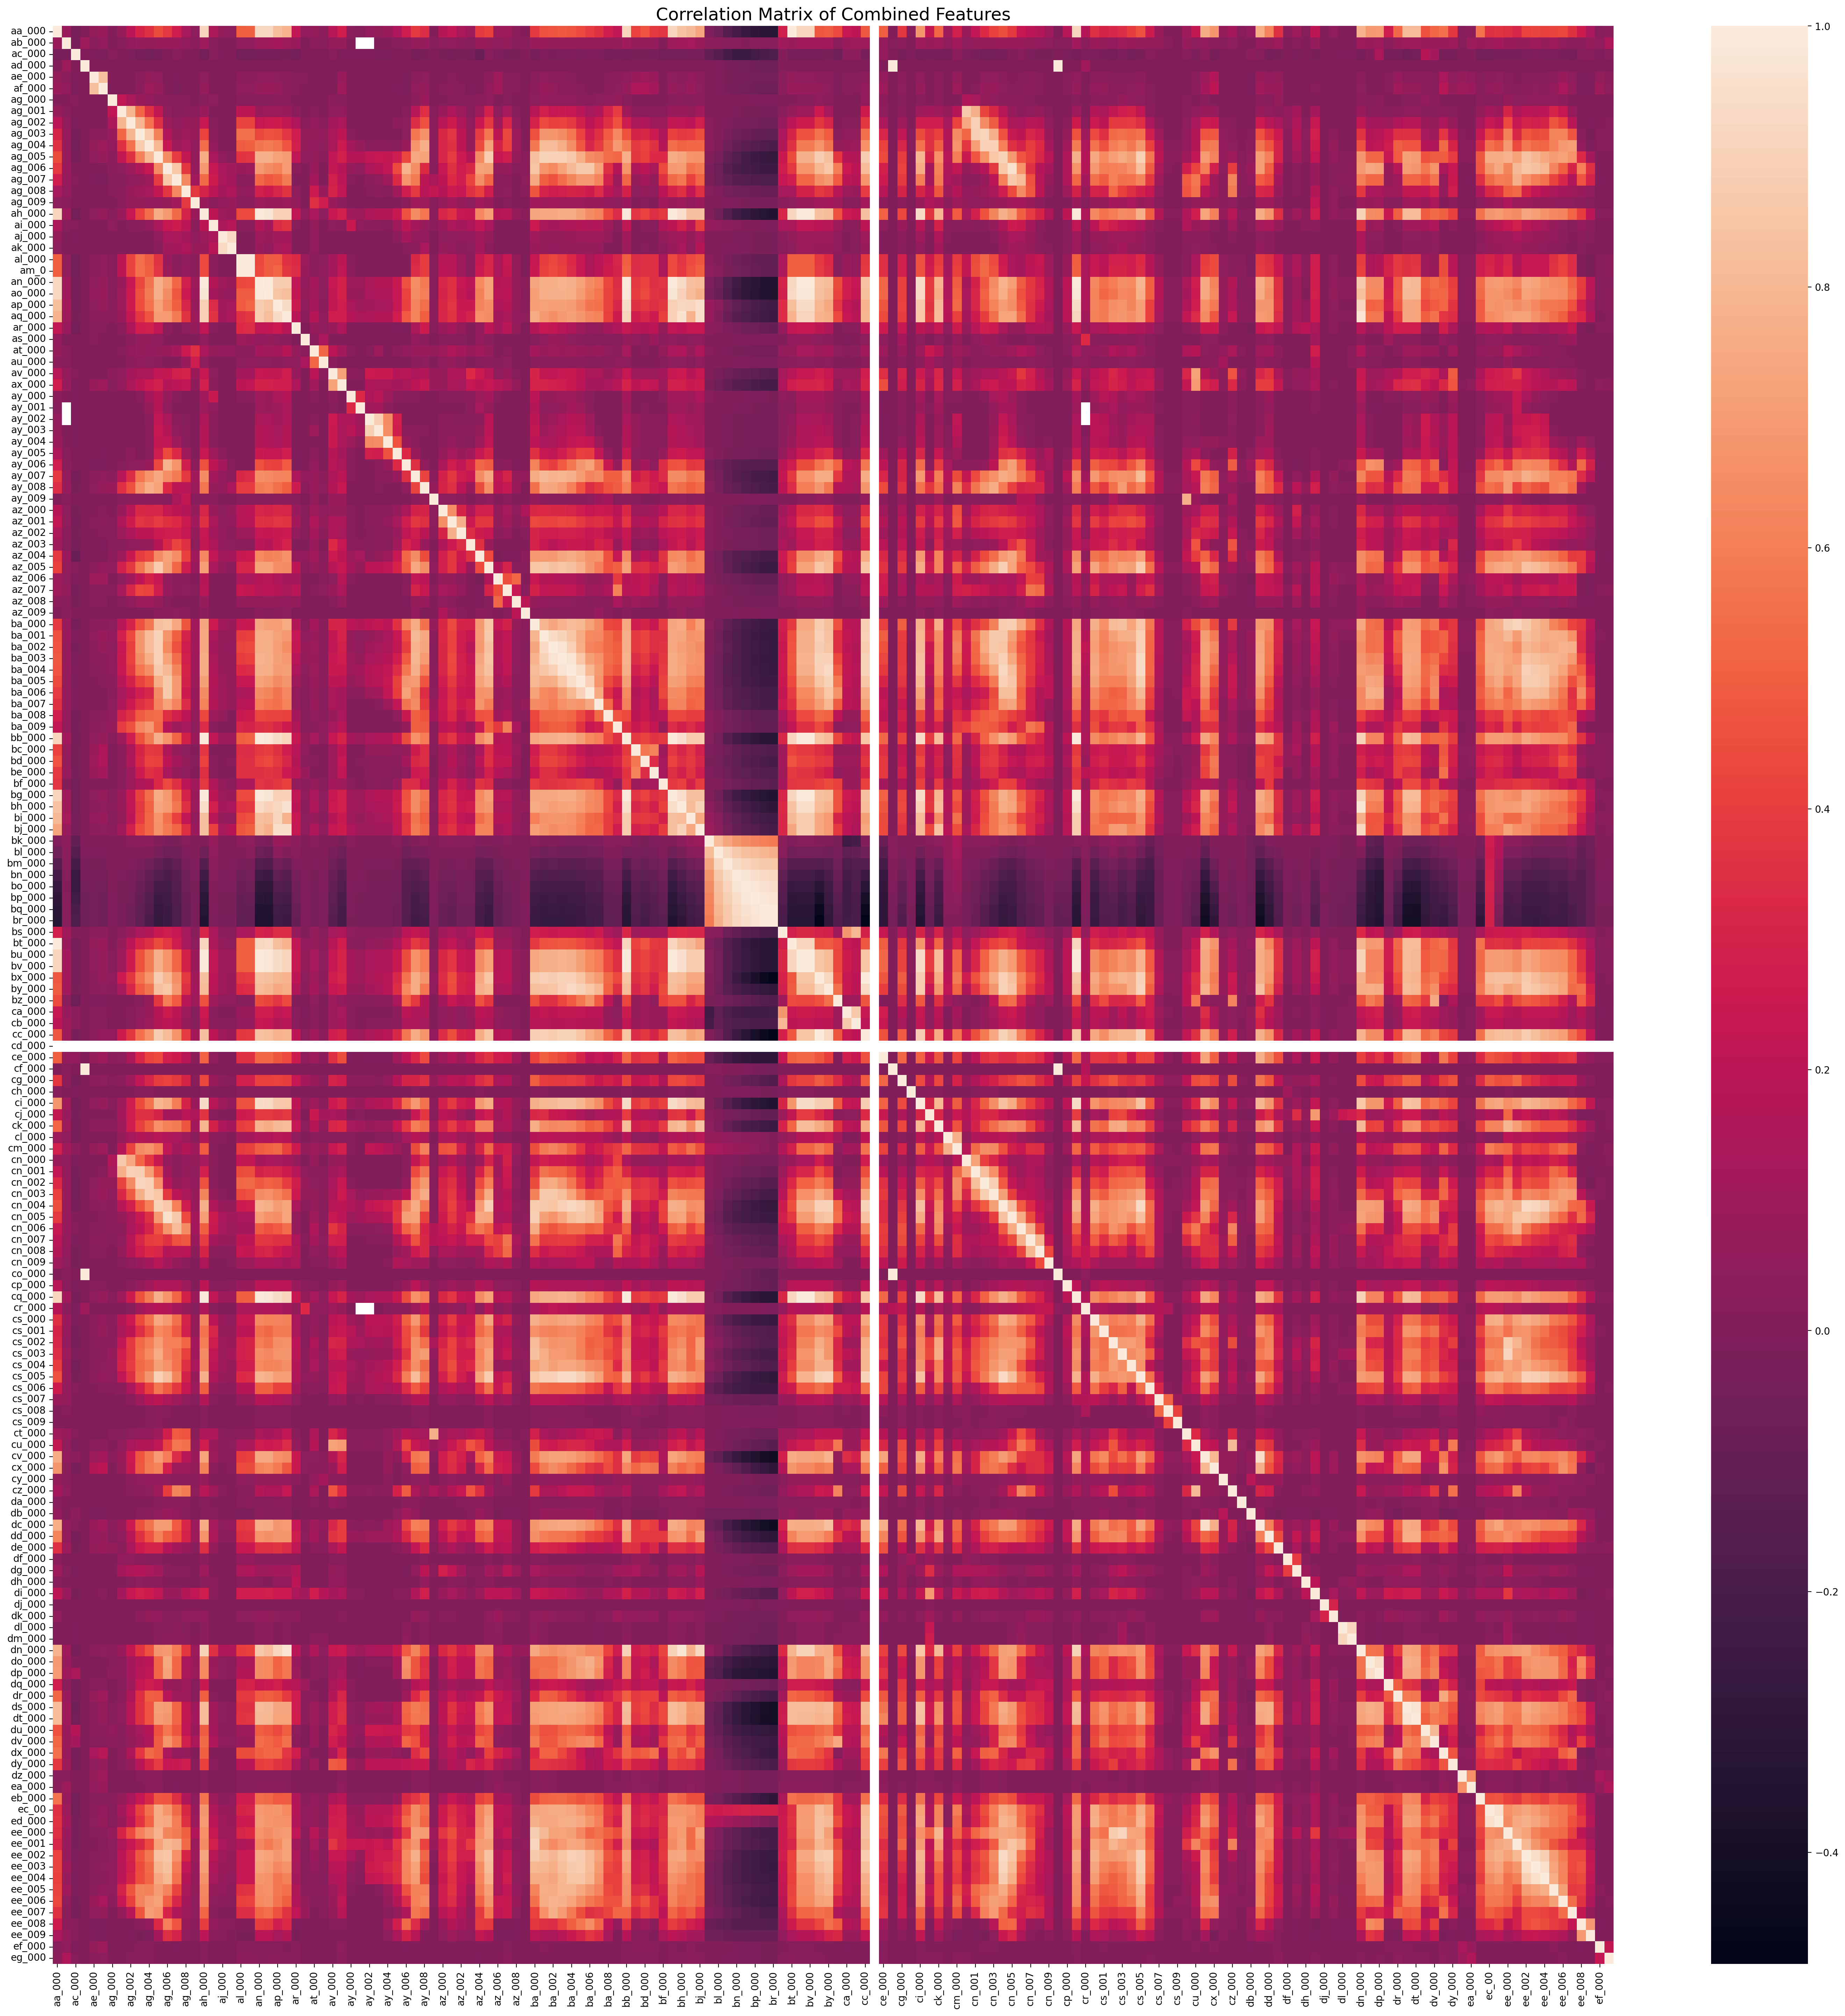

In [9]:
fig = plt.figure(figsize=(36, 36), dpi=200)
corr_matrix = combined_features.corr()
corr_heatmap = sns.heatmap(corr_matrix)
corr_heatmap.set_title('Correlation Matrix of Combined Features', fontdict={'fontsize': 18})

iv. Pick √170 features with highest CV , and make scatter plots and box plots
for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [10]:
features = round(math.sqrt(170))
selected_features_df = pd.DataFrame(coeff_variation).reset_index()
selected_features_df.columns = ['Feature', 'Coefficient_of_Variation']
selected_features_list = selected_features_df[:features]['Feature'].tolist()
highest_cv_dataframe = pd.concat([combined_features[selected_features_list], pd.concat([Y_train, Y_test], ignore_index=True)], axis='columns')
highest_cv_dataframe.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,class
0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,0
1,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,0
2,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,0
3,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0
4,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,0


Text(0.5, 0.98, 'Scatterplot of the features with best Coefficient of Variation (with goal variable)')

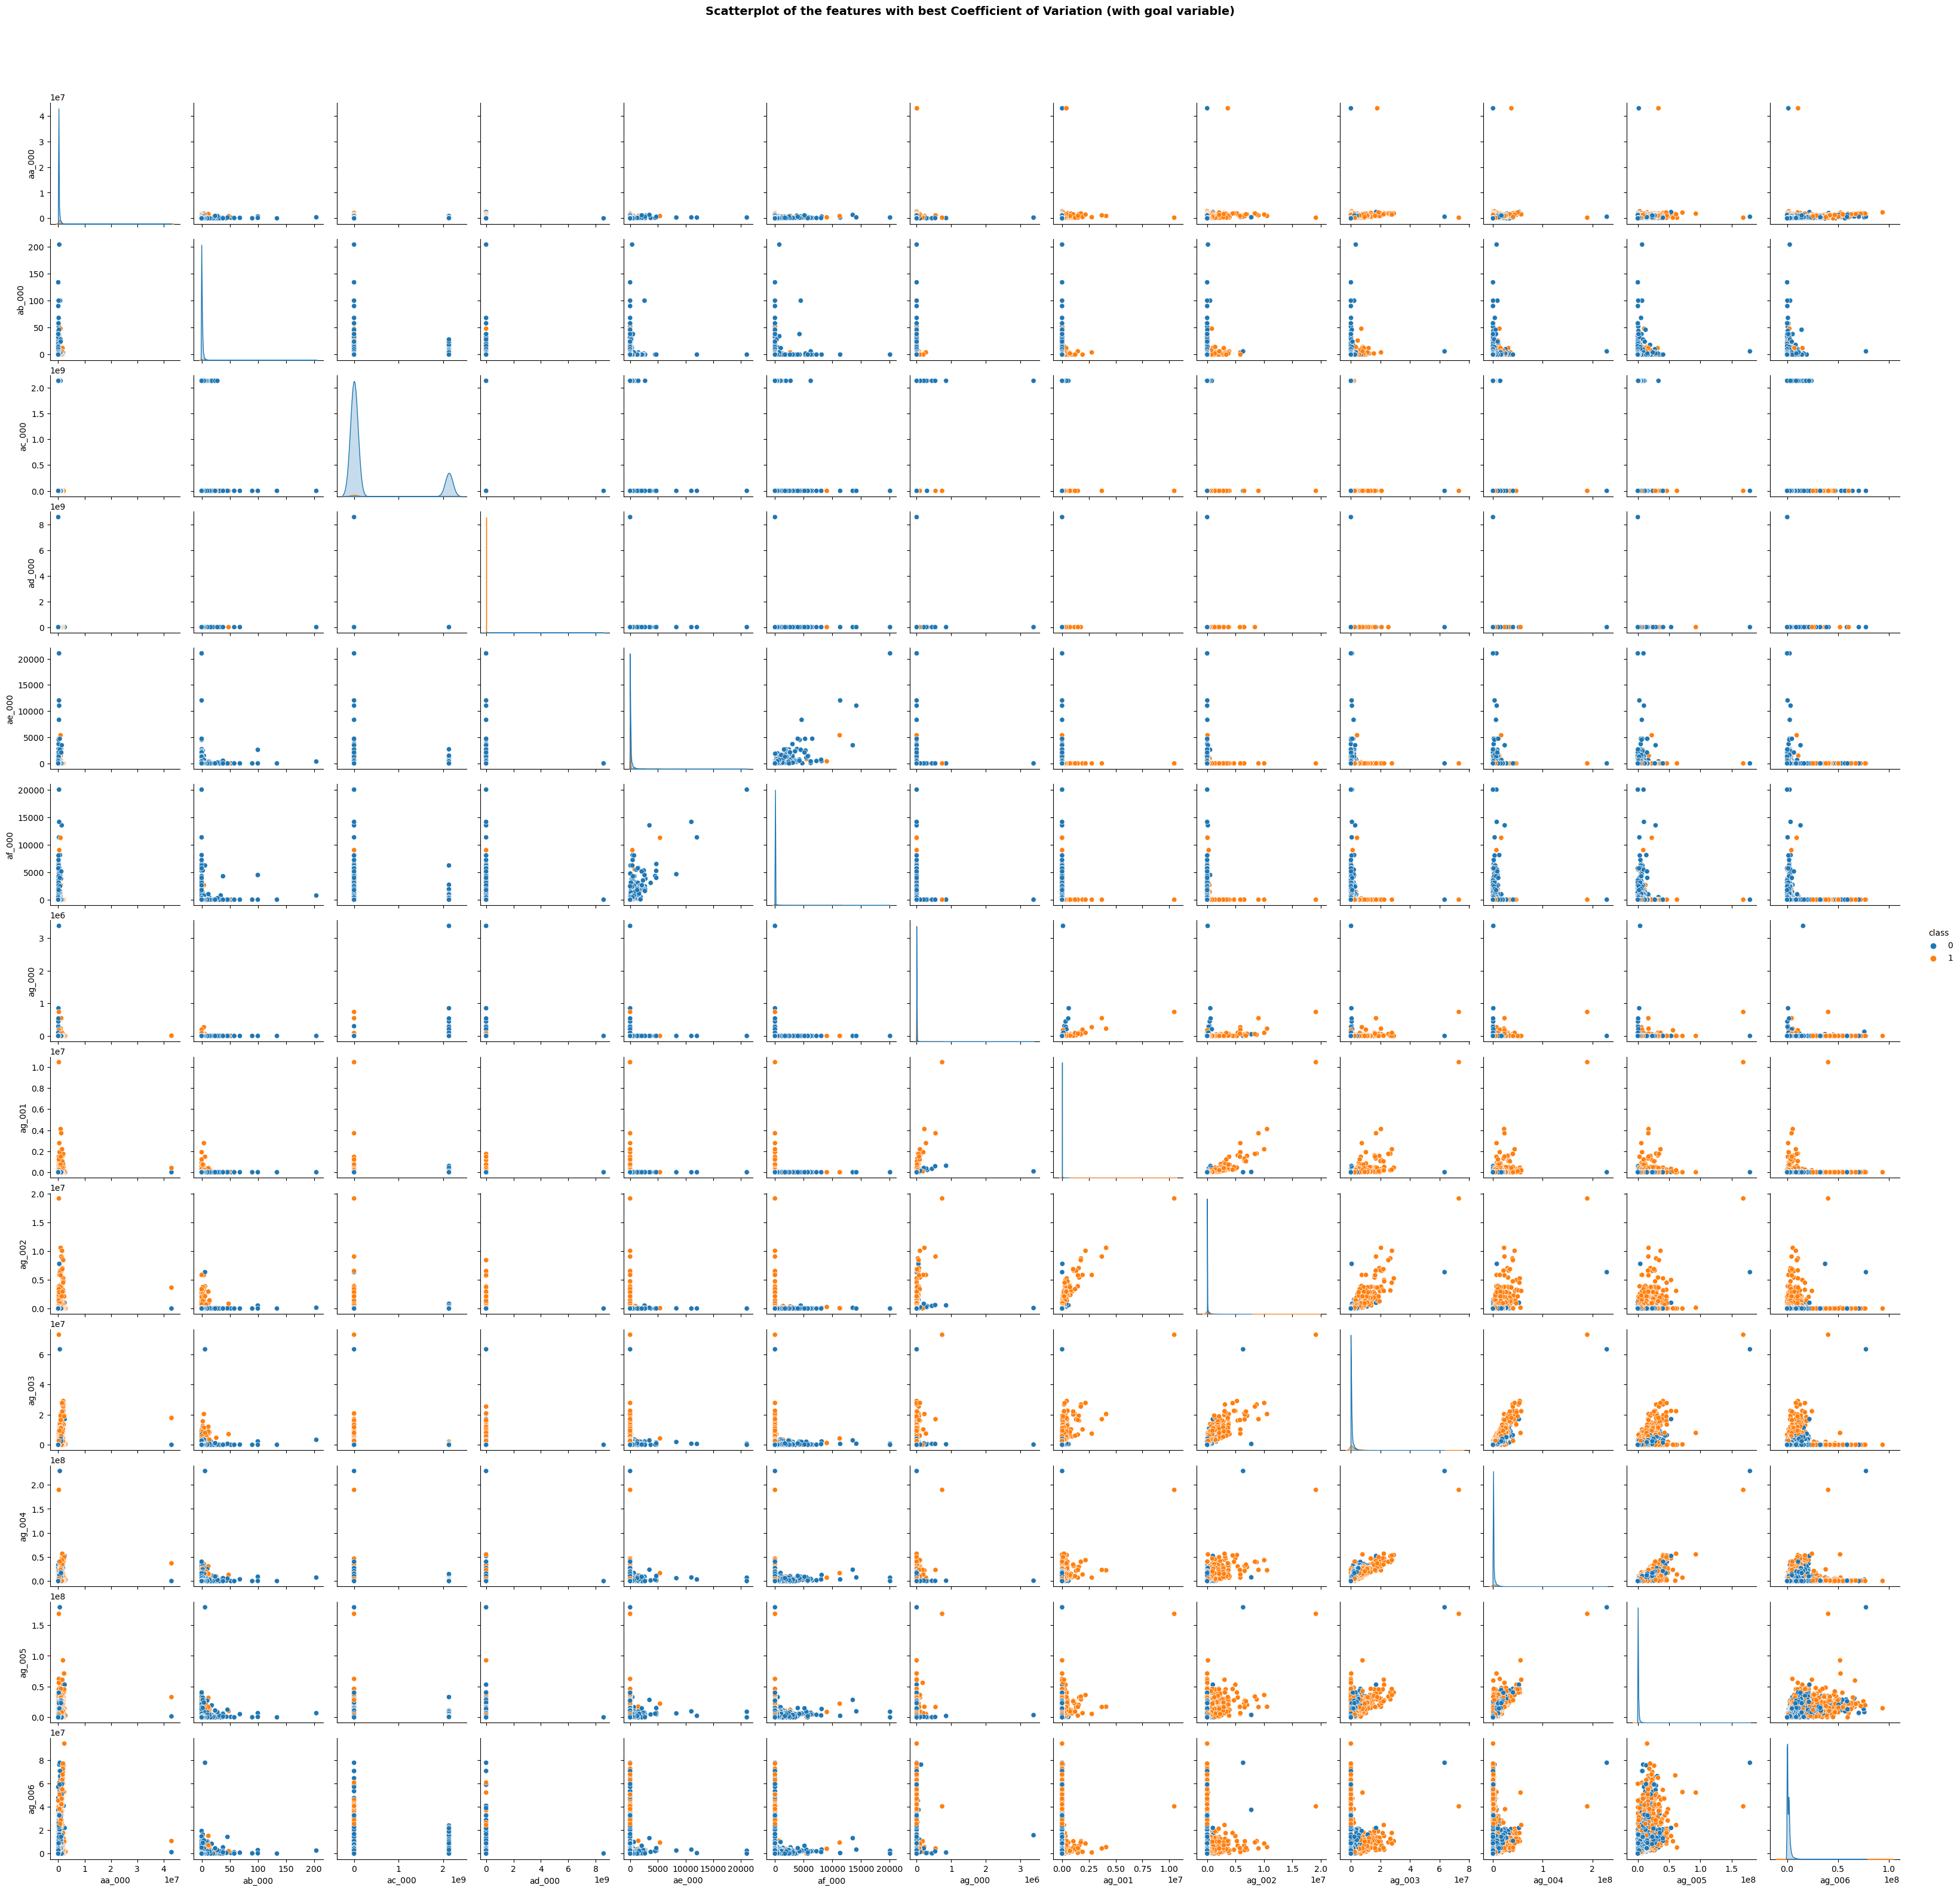

In [11]:
figure = sns.pairplot(data=highest_cv_dataframe, hue='class')
plt.subplots_adjust(top=.93)
figure.fig.suptitle('Scatterplot of the features with best Coefficient of Variation (with goal variable)', fontsize=14, weight='bold')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'aa_000'),
  Text(1, 0, 'ab_000'),
  Text(2, 0, 'ac_000'),
  Text(3, 0, 'ad_000'),
  Text(4, 0, 'ae_000'),
  Text(5, 0, 'af_000'),
  Text(6, 0, 'ag_000'),
  Text(7, 0, 'ag_001'),
  Text(8, 0, 'ag_002'),
  Text(9, 0, 'ag_003'),
  Text(10, 0, 'ag_004'),
  Text(11, 0, 'ag_005'),
  Text(12, 0, 'ag_006'),
  Text(13, 0, 'class')])

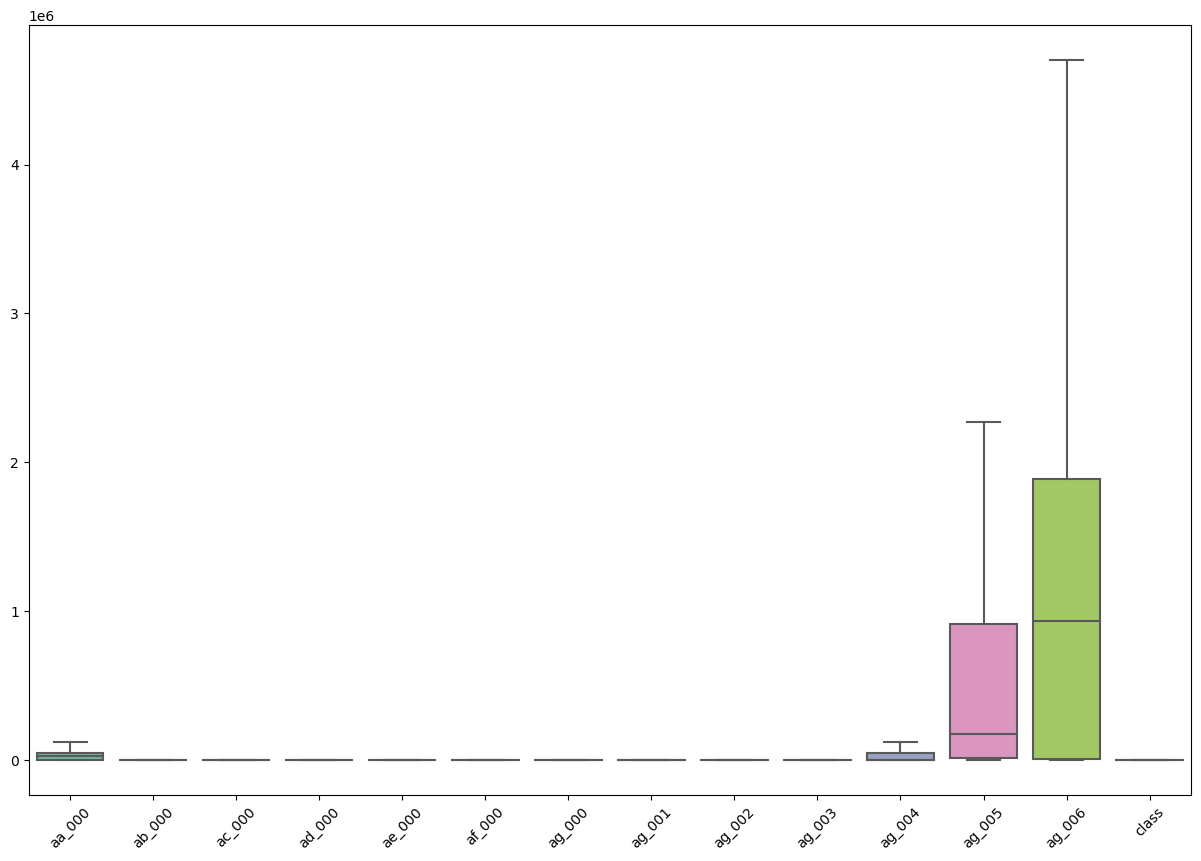

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot(data=highest_cv_dataframe, palette='Set2', showfliers=False)
plt.xticks(rotation=45)

v. Determine the number of positive and negative data. Is this data set imbalanced?

In [13]:
print('Number of positive and negative (1,0) in training dataset:')
train_data['class'].value_counts()

Number of positive and negative (1,0) in training dataset:


class
0    59000
1     1000
Name: count, dtype: int64

In [14]:
print('Number of positive and negative (1,0) in testing dataset:')
test_data['class'].value_counts()

Number of positive and negative (1,0) in testing dataset:


class
0    15625
1      375
Name: count, dtype: int64


(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [15]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=0, oob_score=True)
random_forest = random_forest.fit(X_train, Y_train)

training set Confusion matrix:
 [[59000     0]
 [    0  1000]]
Training error: 0.0
Accuracy of the training set: 1.0
Area under the curve (AUC) 1.0


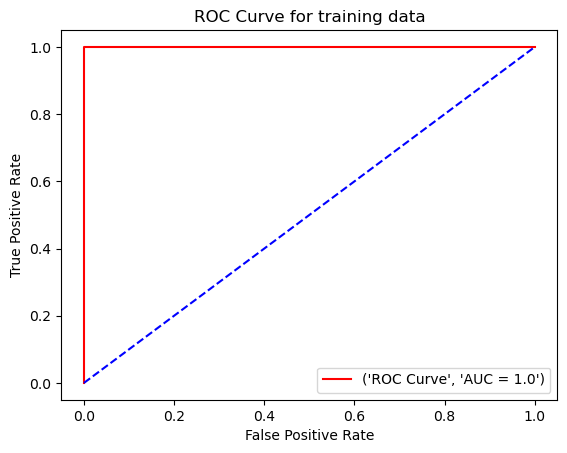

In [16]:
y_train_predictions = random_forest.predict(X_train)

training_Conf_matrix = confusion_matrix(Y_train, y_train_predictions)
print('training set Confusion matrix:\n', training_Conf_matrix)

train_accuracy = accuracy_score(Y_train, y_train_predictions)
trainingError = 1 - train_accuracy
print('Training error:', trainingError)
print('Accuracy of the training set:', train_accuracy)

fpr, tpr, _ = roc_curve(Y_train, y_train_predictions)

trainingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", trainingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(trainingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for training data')
plt.show()

testing set Confusion matrix:
 [[15607    18]
 [  106   269]]
Testing error: 0.007750000000000035
Accuracy of the testing set: 0.99225
Area under the curve (AUC) 0.8580906666666667


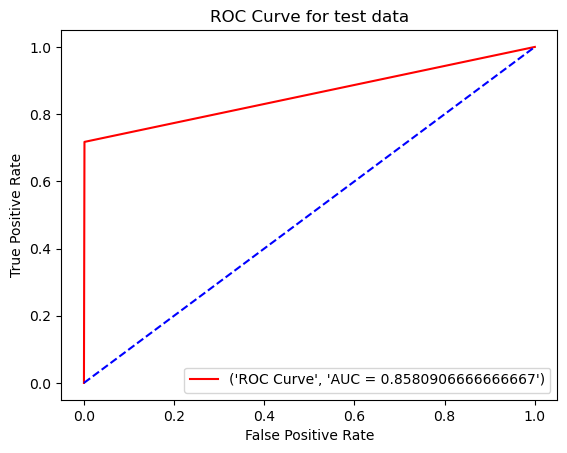

In [17]:
y_test_predictions = random_forest.predict(X_test)

testing_Conf_matrix = confusion_matrix(Y_test, y_test_predictions)
print('testing set Confusion matrix:\n', testing_Conf_matrix)

test_accuracy = accuracy_score(Y_test, y_test_predictions)
testingError = 1 - test_accuracy
print('Testing error:', testingError)
print('Accuracy of the testing set:', test_accuracy)

fpr, tpr, _ = roc_curve(Y_test, y_test_predictions)

testingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", testingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(testingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for test data')
plt.show()

In [18]:
oob_score = 1 - random_forest.oob_score_
print('Out of Bag error estimate:', oob_score)
print('Test error:', testingError)

Out of Bag error estimate: 0.0059833333333333405
Test error: 0.007750000000000035


(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

In [19]:
random_forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced", random_state=0, oob_score=True)
random_forest = random_forest.fit(X_train, Y_train)

training set Confusion matrix:
 [[59000     0]
 [    1   999]]
Training error: 1.666666666666483e-05
Accuracy of the training set: 0.9999833333333333
Area under the curve (AUC) 0.9995


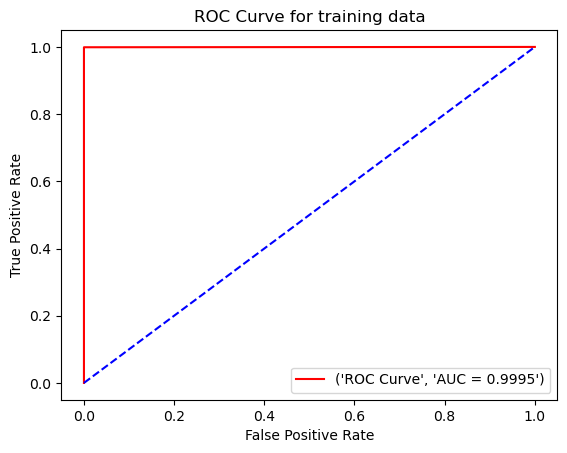

In [20]:
y_train_predictions = random_forest.predict(X_train)

training_Conf_matrix = confusion_matrix(Y_train, y_train_predictions)
print('training set Confusion matrix:\n', training_Conf_matrix)

train_accuracy = accuracy_score(Y_train, y_train_predictions)
trainingError = 1 - train_accuracy
print('Training error:', trainingError)
print('Accuracy of the training set:', train_accuracy)

fpr, tpr, _ = roc_curve(Y_train, y_train_predictions)

trainingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", trainingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(trainingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for training data')
plt.show()

Confusion matrix on testing set:
 [[15606    19]
 [  156   219]]
Testing error: 0.010937500000000044
Accuracy of the testing set: 0.9890625
Area under the curve (AUC) 0.791392


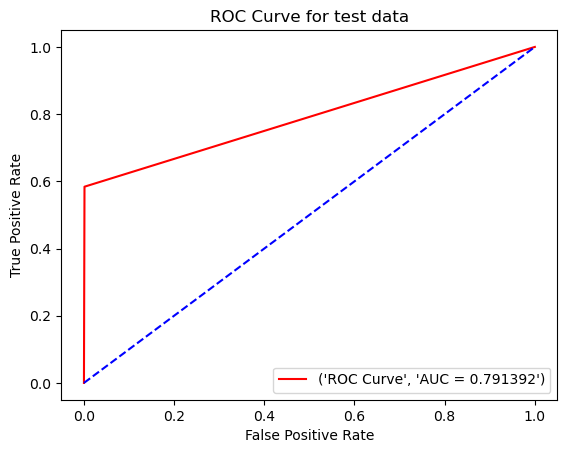

In [21]:
y_test_predictions = random_forest.predict(X_test)

testing_Conf_matrix = confusion_matrix(Y_test, y_test_predictions)
print('Confusion matrix on testing set:\n', testing_Conf_matrix)

test_accuracy = accuracy_score(Y_test, y_test_predictions)
testingError = 1 - test_accuracy
print('Testing error:', testingError)
print('Accuracy of the testing set:', test_accuracy)

fpr, tpr, _ = roc_curve(Y_test, y_test_predictions)

testingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", testingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(testingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for test data')
plt.show()

In [22]:
oob_score = 1 - random_forest.oob_score_
print('Out of Bag error estimate:', oob_score)
print('Test error:', testingError)

Out of Bag error estimate: 0.007616666666666716
Test error: 0.010937500000000044


(e) XGBoost and Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can
be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has 􏰀j βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.
One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [23]:
power_values = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4], dtype=int)
alphas = 10.0 ** power_values
param_grid = {'reg_alpha': alphas}

In [24]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb_search = GridSearchCV(n_jobs=-1, estimator=xgb_classifier, param_grid=param_grid, cv=10)
xgb_search.fit(X_train, Y_train)
best_model = xgb_search.best_estimator_
print('Best Alpha = ', xgb_search.best_params_)

Best Alpha =  {'reg_alpha': 0.0001}


Confusion matrix on training set:
 [[58524   476]
 [   12   988]]
Training error: 0.008133333333333326
Accuracy of the training set: 0.9918666666666667
Area under the curve (AUC) for training set: 0.9899661016949152


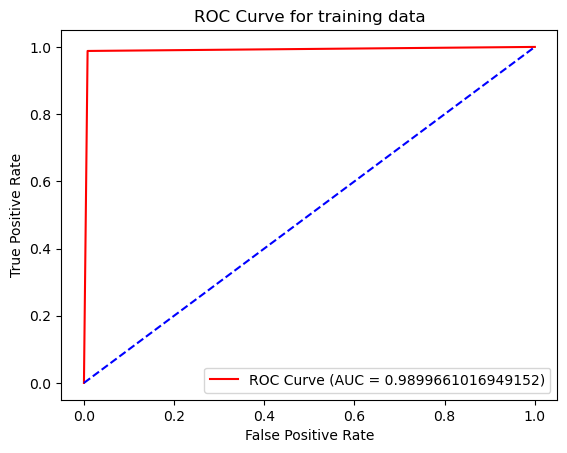

In [33]:
y_train_predictions = best_model.predict(X_train)

training_Conf_matrix = confusion_matrix(Y_train, y_train_predictions)
print('Confusion matrix on training set:\n', training_Conf_matrix)

train_accuracy = accuracy_score(Y_train, y_train_predictions)
trainingError = 1 - train_accuracy
print('Training error:', trainingError)
print('Accuracy of the training set:', train_accuracy)

fpr_train, tpr_train, _ = roc_curve(Y_train, y_train_predictions)
trainingAUC = auc(fpr_train, tpr_train)
print("Area under the curve (AUC) for training set:", trainingAUC)

plt.plot(fpr_train, tpr_train, color='red', label='ROC Curve (AUC = ' + str(trainingAUC) + ')')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for training data')
plt.show()

Confusion matrix on testing set:
 [[15607    18]
 [   82   293]]
Testing error: 0.006249999999999978
Accuracy of the testing set: 0.99375
Area under the curve (AUC) 0.8900906666666667


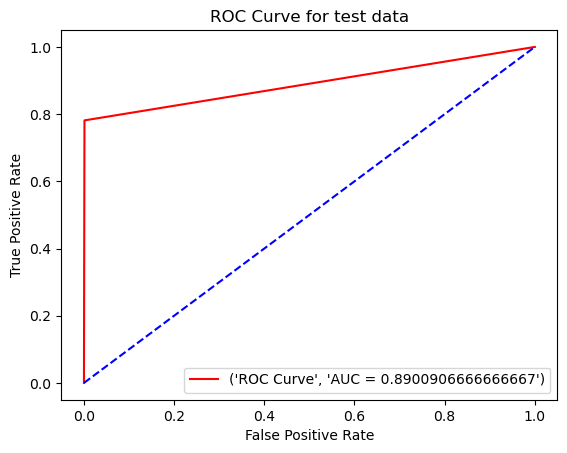

In [26]:
y_test_predictions = best_model.predict(X_test)

testing_Conf_matrix = confusion_matrix(Y_test, y_test_predictions)
print('Confusion matrix on testing set:\n', testing_Conf_matrix)

test_accuracy = accuracy_score(Y_test, y_test_predictions)
testingError = 1 - test_accuracy
print('Testing error:', testingError)
print('Accuracy of the testing set:', test_accuracy)

fpr, tpr, _ = roc_curve(Y_test, y_test_predictions)

testingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", testingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(testingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for test data')
plt.show()

(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBosst with L1-penalized lo- gistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [29]:
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)

if np.isnan(X_train_imputed).any():
    X_train_imputed = X_train_imputed[~np.isnan(X_train_imputed).any(axis=1)]
    Y_train = Y_train[~np.isnan(X_train_imputed).any(axis=1)]

smote = SMOTE()
smote_X_train, smote_Y_train = smote.fit_resample(X_train_imputed, Y_train)

In [32]:
xgb_search = GridSearchCV(n_jobs=-1, 
                          estimator=xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1), 
                          param_grid=param_grid,
                          cv=10)
xgb_search = xgb_search.fit(smote_X_train, smote_Y_train)

best_model = xgb_search.best_estimator_

print('Best Alpha = ', xgb_search.best_params_)

Best Alpha =  {'reg_alpha': 0.01}


Confusion matrix on training set:
 [[58524   476]
 [   12   988]]
Training error: 0.008133333333333326
Accuracy of the training set: 0.9918666666666667
Area under the curve (AUC) 0.9899661016949152


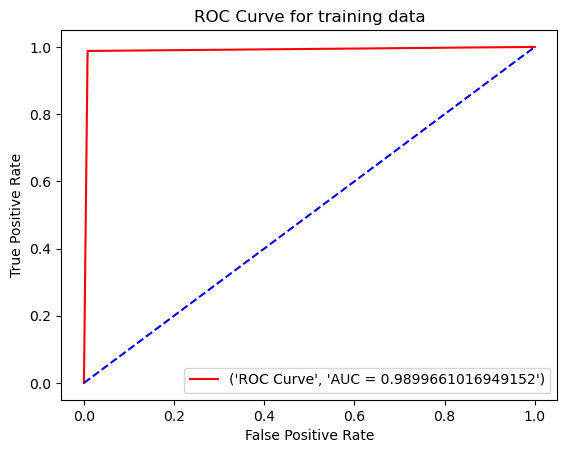

In [35]:
y_train_predictions = best_model.predict(X_train)

training_Conf_matrix = confusion_matrix(Y_train, y_train_predictions)
print('Confusion matrix on training set:\n', training_Conf_matrix)

train_accuracy = accuracy_score(Y_train, y_train_predictions)
trainingError = 1 - train_accuracy
print('Training error:', trainingError)
print('Accuracy of the training set:', train_accuracy)

fpr, tpr, _ = roc_curve(Y_train, y_train_predictions)

trainingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", trainingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(trainingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for training data')
plt.show()

Confusion matrix on testing set:
 [[15450   175]
 [   66   309]]
Testing error: 0.015062499999999979
Accuracy of the testing set: 0.9849375
Area under the curve (AUC) 0.9064


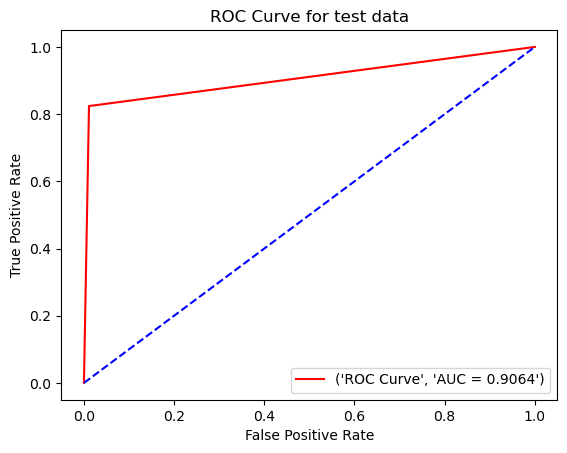

In [36]:
y_test_predictions = best_model.predict(X_test)

testing_Conf_matrix = confusion_matrix(Y_test, y_test_predictions)
print('Confusion matrix on testing set:\n', testing_Conf_matrix)

test_accuracy = accuracy_score(Y_test, y_test_predictions)
testingError = 1 - test_accuracy
print('Testing error:', testingError)
print('Accuracy of the testing set:', test_accuracy)

fpr, tpr, _ = roc_curve(Y_test, y_test_predictions)

testingAUC = auc(fpr, tpr)
print("Area under the curve (AUC)", testingAUC)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=('ROC Curve', 'AUC = ' + str(testingAUC)))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for test data')
plt.show()

2. ISLR 6.6.3

a) As the regularization parameter, denoted by  s, increases from 0, the training residual sum of squares (RSS) will exhibit a consistent downward trend. This phenomenon arises because larger values of  s gradually satisfy the conditions for least squares, resulting in a reduction in training error.  

b) Initially, the test RSS will decrease as  s grows from 0, indicating an improvement in model performance as the flexibility of the model increases. However, beyond a certain threshold, the test RSS will begin to rise, forming a U-shaped curve. This pattern emerges due to the balance between model complexity and generalization: initially, increased flexibility improves performance, but excessive flexibility leads to overfitting, causing the test RSS to increase.  

c) The variance of the model predictions will steadily increase with the regularization parameter s. This occurs because larger values of  s expand the constraint region, allowing for greater model flexibility and consequently higher variance in predictions.  

d) On the other hand, the squared bias of the model will steadily decrease as s increases. This trend occurs because higher values of  s result in greater model flexibility, allowing the model to capture more complex relationships in the data and thereby reducing bias.  

e) The irreducible error, stemming from inherent noise in the data, will remain constant regardless of the regularization parameter s. This error component persists independently of the model's flexibility, as it represents the noise inherent in the underlying data generating process.

3. ISLR, 6.6.5 - Added Images

4. ISLR 8.4.5

Approach 1 - Majority Vote - Final Classification = Red

In this approach, the final classification is determined by a majority vote among the predictions. Specifically, the class with the highest number of predictions is chosen as the final classification. In this case, the number of predictions indicating the class "red" is greater (6 out of 10) compared to the predictions for the class "green" (4 out of 10), as the threshold probability for considering a prediction as "red" is set at 0.5.

Approach 2 - Average Probability - Final Classification = Green

In this approach, the final classification is based on the average probability of the predictions. If the mean probability falls below a certain threshold (in this case, 0.5), the classification defaults to a specific class. Here, the mean probability calculated from the predictions is 0.45, which is less than 0.5. Consequently, the final classification is determined to be "green".

5. ISLR 9.7.3

In [37]:
X1 = [3, 2, 4, 1, 2, 4, 4]
X2 = [4, 2, 4, 4, 1, 3, 1]

Y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']

<Axes: xlabel='x1', ylabel='x2'>

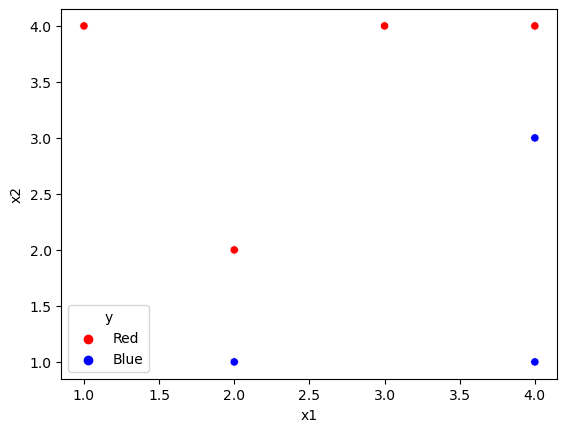

In [38]:
data = {'x1': X1, 'x2': X2, 'y': Y}
dataframe = pd.DataFrame(data)

colors = {"Blue": "blue", "Red": "red"}
sns.scatterplot(data=dataframe, x='x1', y='x2', hue='y', palette=colors)

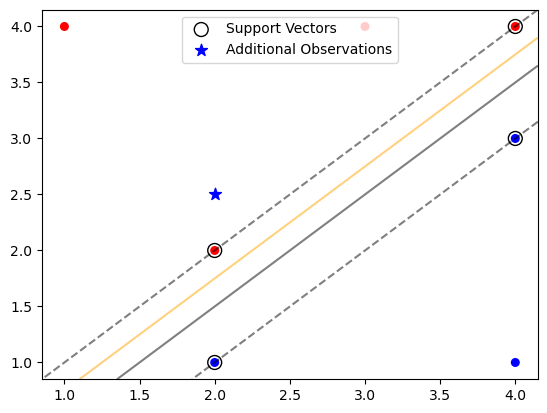

In [41]:
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np

df = dataframe

X = df[['x1', 'x2']]  
Y = df['y'] 

model = svm.SVC(kernel='linear', C=1000)
model.fit(X, Y)

plt.scatter(X['x1'], X['x2'], c=Y, s=30, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(
    XX, YY, Z, 
    colors='k', 
    levels=[-1, 0, 1], 
    alpha=0.5, 
    linestyles=['--', '-', '--'], 
    label='Decision Boundaries'
)

ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors='none',
    edgecolors='k',
    label='Support Vectors'
)

ax.contour(XX, YY, Z - 0.5, 
           colors='orange', 
           levels=[0], 
           alpha=0.5, 
           linestyles=['-'], 
           lw=3)

ax.scatter([2.0], [2.5], 
           color='blue', 
           marker='*', 
           s=80, label='Additional Observations')

ax.legend(loc='upper center')
plt.show()

b) The central black line represents the mathematical equation of the hyperplane.

d) Dashed lines represent the margins surrounding the hyperplane.

e) Points enclosed by black circles indicate the support vectors, which are the observations lying on the margins.

g) The orange line represents a hyperplane that is suboptimal, meaning it does not effectively separate the classes.

h) The star-shaped point indicates that the two classes are no longer completely separable by a single hyperplane. This suggests that there may be some overlap or ambiguity in the classification of certain observations.

Classify Red = −1/2 + X1 − X2 ≤ 0

Classify Blue = −1/2 + X1 − X2 > 0

In [43]:
model.support_vectors_

array([[2., 1.],
       [4., 3.],
       [2., 2.],
       [4., 4.]])

The seventh observation here is not a support vector, implying that any slight movement of the observation does not affect the maximal margin hyperplane.